# Introduction

In this notebook, we demonstrate the steps needed create a model for predicting Remaining Useful Life for turbofan engines based on data collected by devices and routed into storage via the IoT Hub. The notebook assumes that you have complete the device data generation steps from the [IoT  Edge for Machine Learning](aka.ms/IoTEdgeMLPaper). The data generated from the devices needs to be in an Azure Storage account blob container in the same Azure Subscription as you will use to create the Azure Machine Learning service workspace using this notebook.  

The steps we will complete in this notebooks are:
   1. Create a Machine Learning service workspace for managing the experiments, compute, and models for this sample
   1. Load training data from Azure Storage
   1. Prepare the data for training the model
   1. Explore the data 
   1. Remotely train the model
   1. Test the model using test data

The intent is not to provide an extensive coverage of machine learning in Azure as that is covered in much depth elsewhere [here for example](https://github.com/Azure/MachineLearningNotebooks), but to demonstrate how machine learning can be used with IoT Edge.

# Setup notebook

Please ensure that you are running the notebook under the Python 3.6 kernal. Intall fastavro and setup interactive shell to display output nicely.

>You may see a warning about Matplotlib building the font cache. You may ignore the warning as it is benign.

In [1]:
import os, glob, shutil

if not os.path.exists('./data'):
    os.mkdir('./data')

for f in glob.glob('./*.txt') + glob.glob('./*.csv'):
    shutil.move(f, './data/')

In [2]:
!pip install azureml-sdk
!pip install --upgrade azureml-sdk[notebooks,automl]

Requirement already up-to-date: azureml-sdk[automl,notebooks] in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (1.21.0)


# Set global properties

These properties will be used throughout the notebook.
   * `AZURE_SUBSCRIPTION_ID` - the Azure subscription containing the storage account where device data has been uploaded. We will create the Machine Learning service workspace (ml workspace) in this subscription.
   * `ML_WORKSPACE_NAME`  name to give the ml workspace
   * `AZURE_IOT_HUB_NAME` - name of the Azure IoT Hub used in creating the device data using the DeviceHarness.  See [IoT  Edge for Machine Learning](aka.ms/IoTEdgeMLPaper) for details.
   * `RESOURCE_GROUP_NAME` - name of the resource group where the IoT Hub exists
   * `LOCATION` - the Azure location of the IoT Hub
   * `STORAGE_ACCOUNT_NAME` - name of the Azure Storage account where device data was routed via IoT Hub.
   * `STORAGE_ACCOUNT_KEY` - access key for the Azure Storage account
   * `STORAGE_ACCOUNT_CONTAINER` - name of Azure Storage blob container where device data was routed via IoT Hub.

In [3]:
AZURE_SUBSCRIPTION_ID = '80b2bae0-9f97-4190-a0d1-f57c078442d8'
ML_WORKSPACE_NAME = 'turbofanDemo2'
AZURE_IOT_HUB_NAME = 'IotEdgeAndMlHub-6j45ihvworxhk'
RESOURCE_GROUP_NAME = 'pm'
LOCATION = 'East US'
STORAGE_ACCOUNT_NAME = 'iotedgeandml6j45ihvworx'
STORAGE_ACCOUNT_KEY = 'VDfFXATZfZug6bY4y6UBYVH2oENdgJUVMWV2HS3aziqozxsMfwGG4tzf2lc17/YOTENWiLJXXMeVAoVWAATN0w=='
STORAGE_ACCOUNT_CONTAINER = 'devicedata'

if (AZURE_SUBSCRIPTION_ID == ''
        or ML_WORKSPACE_NAME == ''
        or AZURE_IOT_HUB_NAME == ''
        or RESOURCE_GROUP_NAME == ''
        or LOCATION == ''
        or STORAGE_ACCOUNT_NAME == ''
        or STORAGE_ACCOUNT_KEY == ''
        or STORAGE_ACCOUNT_CONTAINER == ''):
    raise ValueError('All values must be filled in') 

# Create a workspace

## What is an Azure ML Workspace and Why Do I Need One?

An Azure ML workspace is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, operationalization, and the monitoring of operationalized models.

In addition to creating the workspace, the cell below writes a file, config.json, to a ./.azureml/config.json, which allows the Workspace object to be reloaded later.




><font color=gray>_Note: currently Workspaces are supported in the following regions: eastus2, eastus,westcentralus, southeastasia, westeurope, australiaeast, westus2, southcentralus_</font>

You may need to authenticate with Azure when running this cell.  If so you will see a message like: 

```To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code XXXXXXXXX to authenticate.```

If you are logged in with an AAD account you will instead be prompted to allow access to Azure.

Once you authenticate, the cell will finish creating the Workspace.

>To facilitate rerunning the notebook with the same Workspace, the cell first checks for the presence of a config. If it finds the config, it loads the Workspace from the config instead of creating it.

In [4]:
from azureml.core import Workspace
workspace_name = ML_WORKSPACE_NAME
subscription_id = AZURE_SUBSCRIPTION_ID
resource_group = RESOURCE_GROUP_NAME
location = LOCATION

if not os.path.exists('./aml_config'):
    os.mkdir('./aml_config')

#check to see if the workspace has already been created and persisted
if (os.path.exists('./aml_config/.azureml/config.json')):
    ws = Workspace.from_config(path='./aml_config')
else:
    ws = Workspace.create(name=workspace_name,
                          subscription_id=subscription_id,
                          resource_group=resource_group,
                          create_resource_group=True,
                          location=location
                         )

    ws.write_config(path='./aml_config')

## Workspace details

Print the Workspace details.

In [5]:
import azureml.core
import pandas as pd
from azureml.core import Workspace

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

,
SDK version,1.21.0
Subscription ID,80b2bae0-9f97-4190-a0d1-f57c078442d8
Workspace,turbofanDemo2
Resource Group,pm
Location,eastus


# Download data from storage

The first step toward creating a model for RUL is to explore the data and understand its shape. We will download the data for this purpose, realizing that in the case of larger data sets only a sample of the data would be used at this step.

## Register storage account

The Datastore is a convenient construct associated the Workspace to upload/download data, and interact with it from remote compute targets. Register the Azure Storage account and container where device data was routed by IoT Hub using the information about the storage container provided at the beginning of the notebook.


In [6]:
from azureml.core import Datastore

ds = Datastore.register_azure_blob_container(workspace=ws,
                                             datastore_name='turbofan',
                                             container_name=STORAGE_ACCOUNT_CONTAINER,
                                             account_name=STORAGE_ACCOUNT_NAME,
                                             account_key=STORAGE_ACCOUNT_KEY,
                                             create_if_not_exists=False)

## Use Datastore to download data

Use the Datastore to download the files to the local machine. The prefix is the top level path to download, which should be the name of the IoT Hub. 

In [7]:
ds.download(target_path="./data/download", prefix=AZURE_IOT_HUB_NAME)

Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/21/00
Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/21/01
Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/21/02
Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/21/03
Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/22/00
Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/22/03
Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/23/01
Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/23/02
Path already exists. Skipping download for ./data/download/IotEdgeAndMlHub-6j45ihvworxhk/2021/01/18/20/24/00


0

# Load train data

The data we just downloaded represent a series of messages sent by each device stored in [Apache Avro](https://avro.apache.org/docs/current/)(avro) format. We will use the fastavro package to deserialize the records from the avro files.
Here is an example deserialized record from the avro file. 

```json 
{
    "EnqueuedTimeUtc": "2018-12-01T01: 16: 22.0950000Z",
    "Properties": {},
    "SystemProperties": {
        "connectionDeviceId": "Client_3",
        "connectionAuthMethod": {
            "scope": "device",
            "type": "sas",
            "issuer": "iothub",
            "acceptingIpFilterRule": null
        },
        "connectionDeviceGenerationId": "636791290544434625",
        "contentType": "application/json",
        "contentEncoding": "utf-8",
        "enqueuedTime": "2018-12-01T01: 16: 22.0950000Z"
    },
    "Body": b'{
        "CycleTime": 1,
        "OperationalSetting1": -0.0001,
        "OperationalSetting2": 0.0001,
        "OperationalSetting3": 100.0,
        "Sensor1": 518.67,
        "Sensor2": 642.03,
       //Sensor 3-19 ommitted for brevity
        "Sensor20": 38.99,
        "Sensor21": 23.296
    }
}```

Taken together the messages represent a time series of data for multiple engines. Each engine is operating normally at the start of each time series, and develops a fault at some point during the series. The fault grows in magnitude until system failure (i.e. the failure point for the engine is the final cycle in the set). The remaining useful life (RUL) is therefore expressed as: 

$$RUL_{current} = Cycle_{max} - Cycle_{current}$$


## Create utils for loading data from avro files

Define a set of utility methods for loading the data from the avro files. We use thes utilities to load the locally downloaded data. Later in the notebook, these same utilities will form the basis of data processing for remote training (see **Train regression using Azure AutoMl and remote execution** below)

In [8]:
!pip install fastavro
!pip install seaborn

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [9]:
!pip install --upgrade tqdm

!pip install --ignore-installed entrypoints

Requirement already up-to-date: tqdm in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (4.56.0)
  Using cached entrypoints-0.3-py2.py3-none-any.whl (11 kB)
ERROR: azureml-mlflow 1.19.0 has requirement azureml-core~=1.19.0, but you'll have azureml-core 1.21.0.post1 which is incompatible.


In [10]:
import glob
import json
import pandas as pd

from fastavro import reader
from os.path import isfile
from multiprocessing.dummy import Pool as ThreadPool 

# parse connectionDeviceId and return the int part
# (e.g. Client_1 becomes 1)
def get_unit_num (unit_record):
    unit = unit_record["connectionDeviceId"]
    return int(unit.split('_')[1])

# create data row from avro file record
def load_cycle_row(record):
    json_body = record["Body"].decode()
    row = json.loads(json_body)
    row.update({'Unit': get_unit_num(record["SystemProperties"])})
    row.update({'QueueTime': pd.to_datetime(record["EnqueuedTimeUtc"])})
    return row

# add row to data frame
def append_df(base_df, append_df):
    if(base_df is None):
        base_df = pd.DataFrame(append_df)
    else:
        base_df = base_df.append(append_df, ignore_index=True)
    return base_df

# sort rows and columns in dataframe
def sort_and_index(index_data):
    #sort rows and reset index
    index_data.sort_values(by=['Unit', 'CycleTime'], inplace=True)
    index_data.reset_index(drop=True, inplace=True)
    
    #fix up column sorting for convenience in notebook
    sorted_cols = (["Unit","CycleTime", "QueueTime"] 
                   + ["OperationalSetting"+str(i) for i in range(1,4)] 
                   + ["Sensor"+str(i) for i in range(1,22)])

    return index_data[sorted_cols]

# load data from an avro file and return a dataframe
def load_avro_file(avro_file_name):
    with open(avro_file_name, 'rb') as fo:
        file_df = None
        avro_reader = reader(fo)
        print ("load records from file: %s" % avro_file_name)
        for record in avro_reader:
            row = load_cycle_row(record)
            file_df = append_df(base_df=file_df, append_df=[row])
        return file_df

# load data from all avro files in given dir 
def load_avro_directory(avro_dir_name):
    lst = glob.iglob(avro_dir_name, recursive=True)
    files = [x for x in lst if isfile(x)]
    pool = ThreadPool(4)
    results = pool.map(load_avro_file, files)
    pool.close()
    pool.join()

    dir_df = None
    for df in results:
        dir_df = append_df(base_df=dir_df, append_df=df)
    print("loaded %d records" % dir_df.shape[0])
    return sort_and_index(dir_df)

# add max cycle to each row in the data
def add_maxcycle(data_frame):
    # cleanup column if it already exists
    if 'MaxCycle' in data_frame.columns:
        data_frame.drop('MaxCycle', axis=1, inplace=True)

    total_cycles = data_frame.groupby(['Unit']).agg({'CycleTime' : 'max'}).reset_index()
    total_cycles.rename(columns = {'CycleTime' : 'MaxCycle'}, inplace = True)
    return data_frame.merge(total_cycles, how = 'left', left_on = 'Unit', right_on = 'Unit')

# return a remaining useful life class based on RUL
def classify_rul(rul):
     if (rul <= 25):
          return 'F25'
     elif (rul <= 75):
          return 'F75'
     elif (rul <= 150):
          return 'F150'
     else:
          return 'Full'
    
# add remaining useful life and remaing useful life class
# to each row in the data
def add_rul(data_frame):
    data_frame = add_maxcycle(data_frame)
    
    if 'RUL' in data_frame.columns:
        data_frame.drop('RUL', axis=1, inplace=True)
    data_frame['RUL'] = data_frame.apply(lambda r: int(r['MaxCycle'] - r['CycleTime']), axis = 1)

    if 'RulClass' in data_frame.columns:
        data_frame.drop('RulClass', axis=1, inplace=True)
    data_frame['RulClass'] = data_frame.apply(lambda r: classify_rul(r['RUL']), axis = 1)
    
    return data_frame

def create_training_dataset(local_dataset_file):
    features = ["Sensor"+str(i) for i in range(1,22)]
    train_pd = load_avro_directory('./data/download/**/*')
    train_pd = add_rul(train_pd)
    train_pd.to_csv(local_dataset_file)
    ds.upload_files(files=[local_dataset_file], overwrite=True, show_progress=True)


## Use utils to load data from download directory

This step will take several minutes.

In [11]:
import utils
import pandas as pd

# check to see if this step has run before and if it has load the data rather than recreating it
dataset_file_name = 'WebServiceTrain.csv'
local_dataset_file = './data/' + dataset_file_name
if (not os.path.exists(local_dataset_file)):
    create_training_dataset(local_dataset_file)

train_pd = pd.read_csv(local_dataset_file)
train_pd.head(5)

,Unnamed: 0,Unit,CycleTime,QueueTime,OperationalSetting1,OperationalSetting2,OperationalSetting3,Sensor1,Sensor2,Sensor3,...,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycle,RUL,RulClass
0,0,1,1,2021-01-18 20:20:29.912000+00:00,-0.0005,0.0004,100.0,518.67,642.36,1583.23,...,8.4246,0.03,391.0,2388.0,100.0,39.11,23.3537,259,258,Full
1,1,1,2,2021-01-18 20:20:30.131000+00:00,0.0008,-0.0003,100.0,518.67,642.50,1584.69,...,8.4403,0.03,392.0,2388.0,100.0,38.99,23.4491,259,257,Full
2,2,1,3,2021-01-18 20:20:30.272000+00:00,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,...,8.3901,0.03,391.0,2388.0,100.0,38.85,23.3669,259,256,Full
3,3,1,4,2021-01-18 20:20:30.412000+00:00,-0.0020,0.0001,100.0,518.67,642.92,1585.61,...,8.3878,0.03,392.0,2388.0,100.0,38.96,23.2951,259,255,Full
4,4,1,5,2021-01-18 20:20:30.544000+00:00,0.0016,0.0000,100.0,518.67,641.68,1588.63,...,8.3869,0.03,392.0,2388.0,100.0,39.14,23.4583,259,254,Full


## Calculate remaining useful life and RUL class labels

Add RUL for regression training and RulClass for classification

In [12]:
train_pd = utils.add_rul(train_pd)

cols = ['Unit', 'CycleTime', 'MaxCycle', 'RUL', 'RulClass']
#show first 5 rows
train_pd[cols].head(5)

#show last 5 rows for engine 3
train_pd[train_pd['Unit'] == 3][cols].tail(5)

,Unit,CycleTime,MaxCycle,RUL,RulClass
0,1,1,259,258,Full
1,1,2,259,257,Full
2,1,3,259,256,Full
3,1,4,259,255,Full
4,1,5,259,254,Full


,Unit,CycleTime,MaxCycle,RUL,RulClass
729,3,218,222,4,F25
730,3,219,222,3,F25
731,3,220,222,2,F25
732,3,221,222,1,F25
733,3,222,222,0,F25


## Display train data

In [13]:
#show the first five rows
train_pd.head(5)

,Unnamed: 0,Unit,CycleTime,QueueTime,OperationalSetting1,OperationalSetting2,OperationalSetting3,Sensor1,Sensor2,Sensor3,...,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycle,RUL,RulClass
0,0,1,1,2021-01-18 20:20:29.912000+00:00,-0.0005,0.0004,100.0,518.67,642.36,1583.23,...,8.4246,0.03,391.0,2388.0,100.0,39.11,23.3537,259,258,Full
1,1,1,2,2021-01-18 20:20:30.131000+00:00,0.0008,-0.0003,100.0,518.67,642.50,1584.69,...,8.4403,0.03,392.0,2388.0,100.0,38.99,23.4491,259,257,Full
2,2,1,3,2021-01-18 20:20:30.272000+00:00,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,...,8.3901,0.03,391.0,2388.0,100.0,38.85,23.3669,259,256,Full
3,3,1,4,2021-01-18 20:20:30.412000+00:00,-0.0020,0.0001,100.0,518.67,642.92,1585.61,...,8.3878,0.03,392.0,2388.0,100.0,38.96,23.2951,259,255,Full
4,4,1,5,2021-01-18 20:20:30.544000+00:00,0.0016,0.0000,100.0,518.67,641.68,1588.63,...,8.3869,0.03,392.0,2388.0,100.0,39.14,23.4583,259,254,Full


# Explore the data

Visualize the data to start to get a sense of how features like sensor measurements and operations settings relate to remaining useful life (RUL)

## Sensor readings and RUL

Create a scatterplot for each sensor measurement vs. RUL. Notice that some measurements (e.g. sensor 2) seem to be correlated strongly to RUL whereas other measurements (e.g. sensor 1) stay constant throughout the life of the engine.

    
><font color=gray>_Note: the data is limited to the first 10 engine units for speed of rendering_</font>

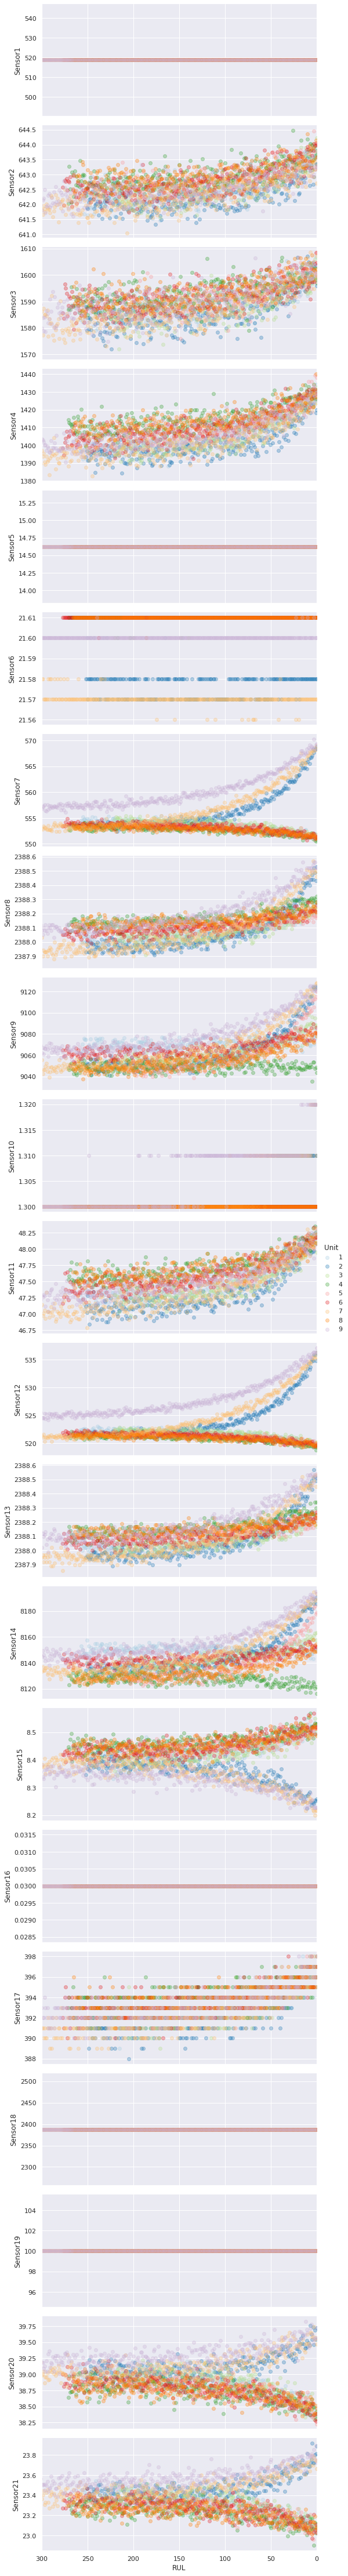

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

#select the data to plot
plotData = train_pd.query('Unit < 10');

sns.set()
g = sns.PairGrid(data=plotData,
                x_vars = ['RUL'],
                y_vars = ["Sensor"+str(i) for i in range(1,22)],
                hue="Unit",
                height=3,
                aspect=2.5,
                palette="Paired")
g = g.map(plt.scatter, alpha=0.3)
g = g.set(xlim=(300,0))
g = g.add_legend()


## Operational settings and RUL

Create a scatterplot for each operation setting vs. RUL. Operational settings do not seem to correlate with RUL.
    
><font color=gray>_Note: the data is limited to the first 10 engine units for speed of rendering_</font>

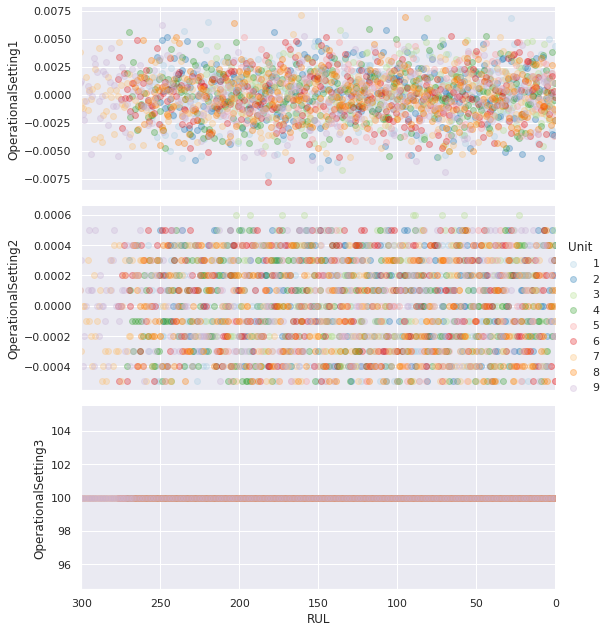

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import utils

plotData = train_pd.query('Unit < 10');
sns.set()
g = sns.PairGrid(data=plotData,
                x_vars = ['RUL'],
                y_vars = ["OperationalSetting"+str(i) for i in range(1,4)],
                hue="Unit",
                height=3,
                aspect=2.5,
                palette="Paired")
g = g.map(plt.scatter, alpha=0.3)
g = g.set(xlim=(300,0))
g = g.add_legend()


# Train model using Azure AutoMl and remote execution

In this section, we will use the Azure Machine Learning service to build a model to predict remaining useful life.

##  Create remote compute target

Azure ML Managed Compute is a managed service that enables data scientists to train machine learning models on clusters of Azure virtual machines, including VMs with GPU support. This code creates an Azure Managed Compute cluster if it does not already exist in your workspace. 

 **Creation of the cluster takes approximately 5 minutes.** If the cluster is already in the workspace this code uses it and skips the creation process.

In [16]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
batchai_cluster_name = 'cpucluster'
cluster_min_nodes = 0
cluster_max_nodes = 3
vm_size = "STANDARD_DS3_V2" 
      
cts = ws.compute_targets
if batchai_cluster_name in cts:
    found = True
    print('Found existing compute target...%s' % batchai_cluster_name)
    compute_target = cts[batchai_cluster_name]
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size, 
                                                                vm_priority = 'lowpriority', #optional
                                                                min_nodes = cluster_min_nodes, 
                                                                max_nodes = cluster_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, batchai_cluster_name, provisioning_config)
    
    # can poll for a minimum number of nodes and for a specific timeout. 
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)
    
    # For a more detailed view of current BatchAI cluster status, use the 'status' property    
    compute_target.status.serialize()

Found existing compute target...cpucluster


# Create a regression model

### Instantiate AutoML

In the interest of time, the cell below uses a short iteration timeout, **3 min**, and a small number of iterations, **10**. Longer iteration timeouts and a greater number of iterations will yield better results

In [17]:
import logging
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset

#name project folder and experiment
experiment_name = 'turbofan-regression-remote'
label_column_name = 'RUL'
dataset = Dataset.Tabular.from_delimited_files(path=[(ds, '/' + dataset_file_name)], separator=',')
train_columns = ["Sensor"+str(i) for i in range(1,22)]
train_columns.append(label_column_name)
dataset = dataset.keep_columns(columns=train_columns)

automl_settings = {
    "iteration_timeout_minutes": 3,
    "iterations": 10,
    "n_cross_validations": 10,
    "primary_metric": 'spearman_correlation',
    "max_cores_per_iteration": -1,
    "max_concurrent_iterations": cluster_max_nodes,
    "verbosity": logging.INFO,
}

Automl_config = AutoMLConfig(task = 'regression',
                             debug_log = 'auto-regress.log',
                             training_data = dataset,
                             compute_target=compute_target,
                             label_column_name=label_column_name,
                             **automl_settings
                            )

### Run the experiment

Run the experiment on the remote compute target and show results as the runs execute. Assuming you have kept the auto_ml settings set in the notebook this step will take several minutes. If you have increased the number of iterations of the iteration timeout it will take longer.

>Note: unlike other cells, this one is not finished until the "Status" in the output below shows "Completed". If it shows a failure, you can check the status in the Azure portal (link will be at the bottom of the output) to learn more.

In [18]:
from azureml.core.experiment import Experiment
from azureml.widgets import RunDetails

experiment=Experiment(ws, experiment_name)
regression_run = experiment.submit(Automl_config, show_output=True)
RunDetails(regression_run).show()

Running on remote.
No run_configuration provided, running on cpucluster with default configuration
Running on remote compute: cpucluster
Parent Run ID: AutoML_31c163aa-ac18-4d57-9228-e516d12c16a1

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

****************************************************************************************************

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

# Explore the results

Explore the results of the automatic training using the run details.

## Reconstitute a run
Given the long running nature of running the experiment the notebook may have been closed or timed out.  In that case, to retrieve the run from the run id set the value of `run_id` to the run_id of the experiment. We use `AutoMLRun` from `azureml.train.automl.run`

In [19]:
from azureml.train.automl.run import AutoMLRun
from azureml.core.experiment import Experiment
from azureml.core import Workspace

run_id = 'AutoML_xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx'

if 'regression_run' not in globals():
    ws = Workspace.from_config(path='./aml_config')
    experiment_name = 'turbofan-regression-remote'
    experiment=Experiment(ws, experiment_name)
    regression_run = AutoMLRun(experiment = experiment, 
                               run_id = run_id)

regression_run.id

'AutoML_31c163aa-ac18-4d57-9228-e516d12c16a1'

## Retrieve all iterations

View the experiment history and see individual metrics for each iteration run.

In [20]:
children = list(regression_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
normalized_root_mean_squared_log_error,0.064116,0.068249,NaN,0.068378,0.065698,0.070086,NaN,0.058928,0.061031,0.060563
explained_variance,0.677389,0.668237,0.663363,0.659749,0.664376,0.660695,0.556438,0.673112,0.679986,0.681455
root_mean_squared_error,56.124444,56.916766,57.328832,57.638600,57.247205,57.555559,65.817842,57.571958,56.075343,55.773144
spearman_correlation,0.863788,0.859230,0.857388,0.856122,0.858898,0.856676,0.823545,0.863708,0.866043,0.865959
r2_score,0.677176,0.668010,0.663153,0.659521,0.664142,0.660506,0.556059,0.660361,0.677773,0.681210
mean_absolute_percentage_error,36.990627,40.315134,40.871988,41.406451,39.213624,41.722025,106.209783,31.448885,34.281859,34.433101
normalized_median_absolute_error,0.048035,0.049666,0.049948,0.051109,0.050515,0.049499,0.072779,0.045953,0.046413,0.047306
root_mean_squared_log_error,0.401582,0.427468,NaN,0.428279,0.411491,0.438974,NaN,0.369088,0.382260,0.379333
normalized_mean_absolute_error,0.073830,0.075486,0.076203,0.076419,0.075682,0.076025,0.093394,0.073716,0.072751,0.072986
median_absolute_error,25.170254,26.024767,26.172960,26.780885,26.469942,25.937644,38.136258,24.079578,24.320671,24.788560


## Register the best model 

Use the `regression_run` object to get the best model and register it into the workspace. 

In [21]:
best_run, fitted_model = regression_run.get_output()

# register model in workspace
description = 'Aml Model ' + regression_run.id[7:15]
tags = None
regression_run.register_model(description=description, tags=tags)
regression_run.model_id # Use this id to deploy the model as a web service in Azure

Model(workspace=Workspace.create(name='turbofanDemo2', subscription_id='80b2bae0-9f97-4190-a0d1-f57c078442d8', resource_group='pm'), name=AutoML31c163aaa8, id=AutoML31c163aaa8:1, version=1, tags={}, properties={})

'AutoML31c163aaa8'

### Save model information for deployment

Persist the information that we will need to deploy the model in the [turbofan deploy model](./turbofan_deploy_model.ipynb)

In [22]:
import json
import os

model_information = {'regressionRunId': regression_run.id, 'modelId': regression_run.model_id, 'experimentName': experiment.name}
with open('./aml_config/model_config.json', 'w') as fo:
  json.dump(model_information, fo)

# Load test data

In the test set, the time series ends some time prior to system failure. The actual
remaining useful life (RUL) are given in the RUL_*.txt files.  The data in the RUL files is a single vector where the index corresponds to the unit number of the engine and the value corresponds to the actual RUL at the end of the test.

The RUL for a given cycle in the training set is given by adding the RUL at test end (from the RUL vector file) to the maximum cycle in the test data and then subtracting the current cycle:

$$RUL_{current} =  RUL_{TestEnd} + Cycle_{max} - Cycle_{current}$$

Taking unit number 1 as an example:
   * Taking the first value from RUL_FD003.txt gives:       $RUL_{TestEnd} = 44$
   * The final(max) cycle value from test_FD003.txt gives:  $Cycle_{max} = 233$
   * The values for the first 5 cycles for engine 1 are:

|Unit|Cycle|Max Cycle|Test End RUL|Remaining Life|
|-----|-----|-----|-----|-----|
|1|1|233|44|276|
|1|2|233|44|275|
|1|3|233|44|274|
|1|4|233|44|273|
|1|5|233|44|272|



## Define some methods for loading from text files

In [23]:
import json
import utils
import pandas as pd
from os.path import isfile

def add_column_names(data_frame):
    data_frame.columns = (["Unit","CycleTime"]
                          + ["OperationalSetting"+str(i) for i in range(1,4)]
                          + ["Sensor"+str(i) for i in range(1,22)])

def read_data_file(full_file_name):
    data = pd.read_csv(full_file_name, sep = ' ', header = None)
    data.dropna(axis='columns', inplace=True)
    return data

def load_rul_data(full_file_name):
    rul_data = read_data_file(full_file_name)

    # add a column for the unit and fill with numbers 1..n where
    # n = number of rows of RUL data
    rul_data['Unit'] = list(range(1, len(rul_data) + 1))
    rul_data.rename(columns = {0 : 'TestEndRUL'}, inplace = True)
    return rul_data


def load_test_data(test_full_file_name, rul_full_file_name):
    data = read_data_file(test_full_file_name)
    add_column_names(data)
    data = utils.add_maxcycle(data)
    
    rul_data = load_rul_data(rul_full_file_name)
    data = data.merge(rul_data, how = 'left', left_on = 'Unit', right_on = 'Unit')
    data['RUL'] = data.apply(lambda r: int(r['MaxCycle'] + r['TestEndRUL'] - r['CycleTime']), axis = 1)
    data['RulClass'] = data.apply(lambda r: utils.classify_rul(r['RUL']), axis = 1)

    return data


## Read and process the test data

In [24]:
dataset = "FD003" 
rul_file_name = 'data/RUL_' + dataset + '.txt'
test_file_name = 'data/test_' + dataset + '.txt'

test_pd = load_test_data(test_file_name, rul_file_name)
test_pd.head(5)

,Unit,CycleTime,OperationalSetting1,OperationalSetting2,OperationalSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,MaxCycle,TestEndRUL,RUL,RulClass
0,1,1,-0.00,-0.00,100.00,518.67,641.94,1581.93,1396.93,14.62,...,0.03,391,2388,100.00,39.07,23.45,233,44,276,Full
1,1,2,0.00,-0.00,100.00,518.67,642.02,1584.86,1398.90,14.62,...,0.03,391,2388,100.00,39.04,23.48,233,44,275,Full
2,1,3,0.00,-0.00,100.00,518.67,641.68,1581.78,1391.92,14.62,...,0.03,391,2388,100.00,39.10,23.42,233,44,274,Full
3,1,4,0.00,0.00,100.00,518.67,642.20,1584.53,1395.34,14.62,...,0.03,392,2388,100.00,38.97,23.48,233,44,273,Full
4,1,5,-0.00,0.00,100.00,518.67,642.46,1589.03,1395.86,14.62,...,0.03,391,2388,100.00,39.09,23.39,233,44,272,Full


### Serialize test data

Save off the data so that we can use it when we test the web service in the [turbofan deploy model](./turbofan_deploy_model.ipynb) notebook.

In [25]:
test_pd.to_csv('./data/WebServiceTest.csv')

# Test regression model

predict on training and test set and calculate residual values

In [26]:
selected_features = ["Sensor"+str(i) for i in range(1,22)]

#reload data in case the kernel died at some point
if 'train_pd' not in globals():
    train_pd = pd.read_csv("data/WebServiceTrain.csv")

#load the values used to train the model
X_train = train_pd[selected_features]
y_train = train_pd['RUL']

#predict and calculate residual values for train
y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train

train_pd['predicted'] = y_pred_train; 
train_pd['residual'] = y_residual_train

#load the values from the test set
X_test = test_pd[selected_features]
y_test = test_pd['RUL']

#predict and calculate residual values for test
y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

test_pd['predicted'] = y_pred_test;
test_pd['residual'] = y_residual_test

In [27]:
train_pd[['Unit', 'RUL', 'predicted', 'residual']].head(5)
test_pd[['Unit', 'RUL', 'predicted', 'residual']].head(5)

,Unit,RUL,predicted,residual
0,1,258,177.87,80.13
1,1,257,175.64,81.36
2,1,256,141.68,114.32
3,1,255,171.33,83.67
4,1,254,176.17,77.83


,Unit,RUL,predicted,residual
0,1,276,207.78,68.22
1,1,275,198.72,76.28
2,1,274,199.59,74.41
3,1,273,235.62,37.38
4,1,272,205.97,66.03


## Predicted vs. actual

Plot the predicted RUL against the actual RUL.  The dashed line represents the ideal model.

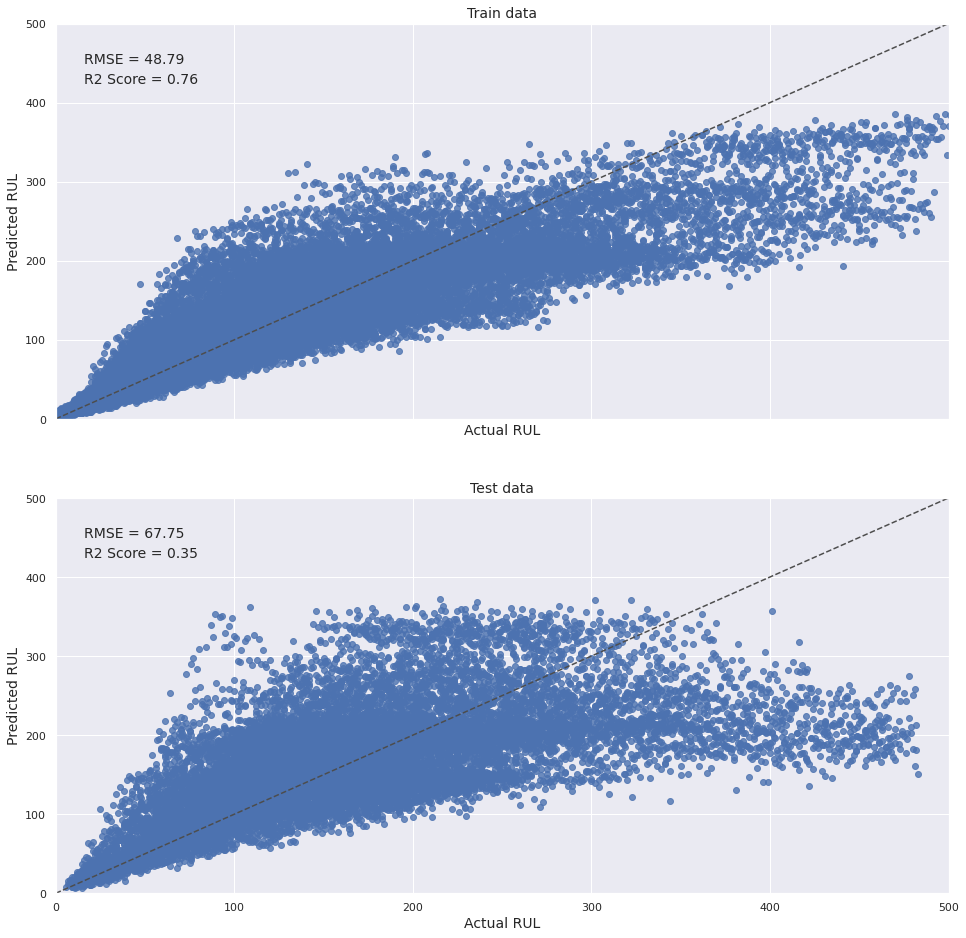

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score

fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(16, 16)

font_size = 14

g = sns.regplot(y='predicted', x='RUL', data=train_pd, fit_reg=False, ax=ax1)
lim_set = g.set(ylim=(0, 500), xlim=(0, 500))
plot = g.axes.plot([0, 500], [0, 500], c=".3", ls="--");

rmse = ax1.text(16,450,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = font_size)
r2 = ax1.text(16,425,'R2 Score = {0:.2f}'.format(r2_score(y_train, y_pred_train)), fontsize = font_size)

g2 = sns.regplot(y='predicted', x='RUL', data=test_pd, fit_reg=False, ax=ax2)
lim_set = g2.set(ylim=(0, 500), xlim=(0, 500))
plot = g2.axes.plot([0, 500], [0, 500], c=".3", ls="--");

rmse = ax2.text(16,450,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = font_size)
r2 = ax2.text(16,425,'R2 Score = {0:.2f}'.format(r2_score(y_test, y_pred_test)), fontsize = font_size)

ptitle = ax1.set_title('Train data', size=font_size)
xlabel = ax1.set_xlabel('Actual RUL', size=font_size)
ylabel = ax1.set_ylabel('Predicted RUL', size=font_size)

ptitle = ax2.set_title("Test data", size=font_size)
xlabel = ax2.set_xlabel('Actual RUL', size=font_size)
ylabel = ax2.set_ylabel('Predicted RUL', size=font_size)

## Predicted vs. residual

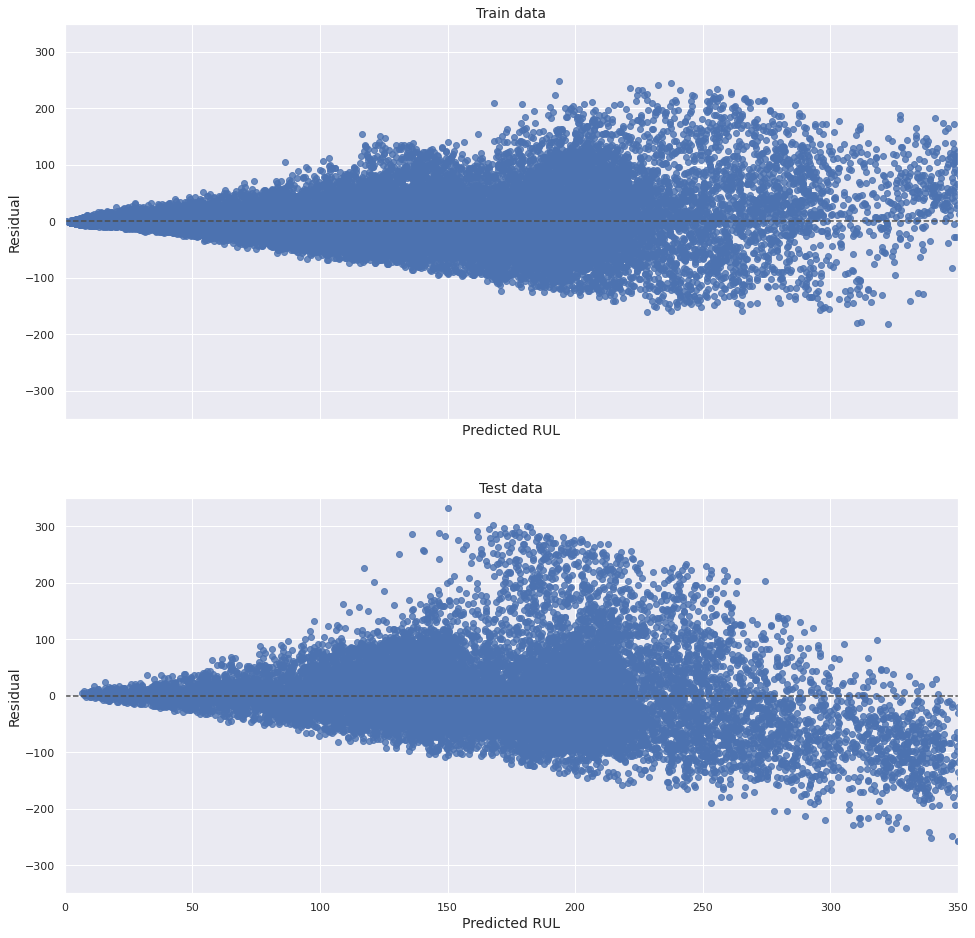

In [29]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(16, 16)

font_size = 14

g = sns.regplot(y='residual', x='predicted', data=train_pd, fit_reg=False, ax=ax1)
lim_set = g.set(ylim=(-350, 350), xlim=(0, 350))
plot = g.axes.plot([0, 350], [0, 0], c=".3", ls="--");

g2 = sns.regplot(y='residual', x='predicted', data=test_pd, fit_reg=False, ax=ax2)
lim_set = g2.set(ylim=(-350, 350), xlim=(0, 350))
plot = g2.axes.plot([0, 350], [0, 0], c=".3", ls="--");

ptitle = ax1.set_title('Train data', size=font_size)
xlabel = ax1.set_xlabel('Predicted RUL', size=font_size)
ylabel = ax1.set_ylabel('Residual', size=font_size)

ptitle = ax2.set_title("Test data", size=font_size)
xlabel = ax2.set_xlabel('Predicted RUL', size=font_size)
ylabel = ax2.set_ylabel('Residual', size=font_size)

## Residual distribution

Plot histogram and Q-Q plot for test and train data to check for normal distibution of residuals

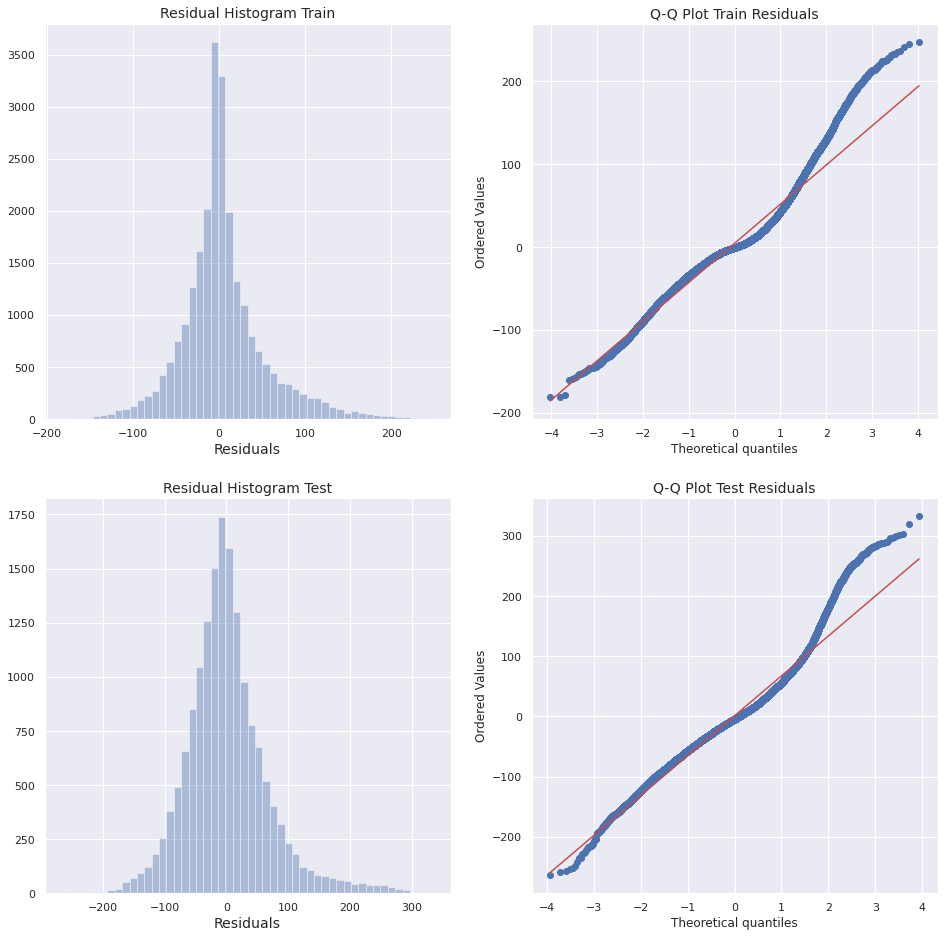

In [30]:
import statsmodels.api as sm
import scipy.stats as stats

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols= 2)
fig.set_size_inches(16, 16)

g = sns.distplot(train_pd['residual'], ax=ax1[0], kde=False)
g = stats.probplot(train_pd['residual'], plot=ax1[1])

g2 = sns.distplot(test_pd['residual'], ax=ax2[0], kde=False)
g2 = stats.probplot(test_pd['residual'], plot=ax2[1])


ptitle = ax1[0].set_title('Residual Histogram Train', size=font_size)
xlabel = ax1[0].set_xlabel('Residuals', size=font_size)
ptitle = ax1[1].set_title('Q-Q Plot Train Residuals', size=font_size)

ptitle = ax2[0].set_title('Residual Histogram Test', size=font_size)
xlabel = ax2[0].set_xlabel('Residuals', size=font_size)
ptitle = ax2[1].set_title('Q-Q Plot Test Residuals', size=font_size)



# Next Steps

Now that we have a working model we want to deploy it as an Azure IoT Edge module.  The [turbofan deploy model](./02-turbofan_deploy_model.ipynb) walks through the steps to create and Edge module.